In [90]:
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
import seaborn as sb
import cv2
from PIL import Image
import tensorflow as tf
from torchvision.models import resnet18
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import os
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', message='Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.')


In [91]:

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device else prints cpu:
print(device)

cuda:0


In [92]:
# Loading dataset using google drive id
!gdown --id 19lsMHa9K0vC7cbFi6rh0ewmnF-KxJfGz

#Unzipping the folder
!unzip -qq archive.zip

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19lsMHa9K0vC7cbFi6rh0ewmnF-KxJfGz
To: /content/archive.zip
100% 226M/226M [00:00<00:00, 241MB/s]
replace Data/Buffalo/Buffalo_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [93]:
PATH = '/content/Data/'
# images = glob.glob( "/content/Data/*/*.jpg")

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

The PrefetchDataset class is a type of dataset that prefetches a number of elements from the dataset in a background thread while the model is training on the current batch. This can help to improve the performance of the training process by reducing the time spent waiting for data to be loaded from disk or memory.

In general, TensorFlow datasets are a convenient way to load and manipulate large amounts of data for use in machine learning models.

In [94]:
train_dataset = tf.keras.utils.image_dataset_from_directory(directory = PATH,
                                                            validation_split=0.2,
                                                            subset='training',
                                                            shuffle=True,
                                                            seed=1,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory = PATH,
                                                                 validation_split=0.2,
                                                                 subset='validation',
                                                                 shuffle=True,
                                                                 seed=1,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 4000 files belonging to 4 classes.
Using 3200 files for training.
Found 4000 files belonging to 4 classes.
Using 800 files for validation.


In [95]:
print(f"Training Dataset type: {type(train_dataset)}")

Training Dataset type: <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


## Splitting Data set
splits a validation dataset into a test dataset and a modified validation dataset, which can be used for training a model and evaluating its performance on an unseen test set.

In [96]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)

# Take a subset of the validation dataset to create the test dataset
test_dataset = validation_dataset.take(val_batches // 5)

# Skip the batches used for the test dataset to create the validation dataset
validation_dataset = validation_dataset.skip(val_batches // 5)

In [97]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 20
Number of test batches: 5


### Checking random Samples
displays random samples generated from training dataset

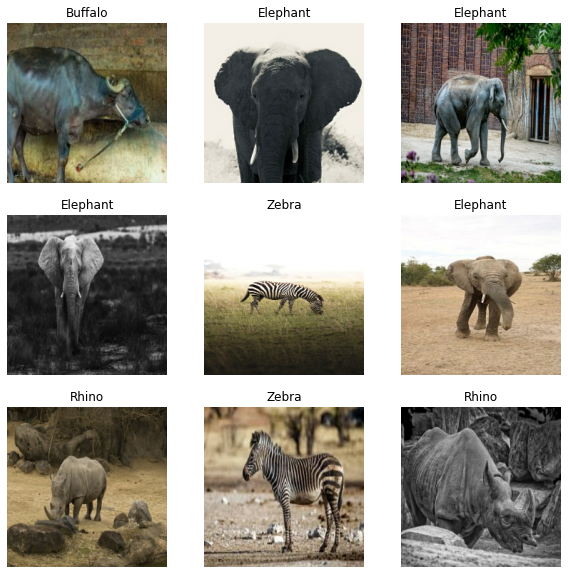

In [98]:
# Get the class names from the train dataset
class_names = train_dataset.class_names

# Create a figure to plot the images
plt.figure(figsize=(10, 10))

# Take a batch of images and labels from the train dataset
for images, labels in train_dataset.take(1):
  
  # Iterate over each image and label in the batch
  for i in range(9):
    
    # Create a subplot for the image
    ax = plt.subplot(3, 3, i + 1)
    
    # Plot the image
    plt.imshow(images[i].numpy().astype("uint8"))
    
    # Set the title of the plot to the corresponding class label
    plt.title(class_names[labels[i]])
    
    # Turn off the axis
    plt.axis("off")


## Classes
prints All the classes for the classification task

In [99]:
class_names

['Buffalo', 'Elephant', 'Rhino', 'Zebra']

## Configure Dataset for performance
Prefetching can significantly speed up the training process by reducing the time it takes for the CPU or GPU to wait for data to be loaded from memory or disk. By prefetching data, TensorFlow can overlap the data loading and model training steps, which can improve the overall training throughput.

In [100]:
# Set the AUTOTUNE constant to dynamically adjust the buffer size
AUTOTUNE = tf.data.AUTOTUNE

# Prefetch the training dataset with buffer size set to AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Prefetch the validation dataset with buffer size set to AUTOTUNE
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Prefetch the test dataset with buffer size set to AUTOTUNE
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


## Data Augumentation
Creates multiple sample by augumenting the available images

In [101]:
# Create a data augmentation model
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

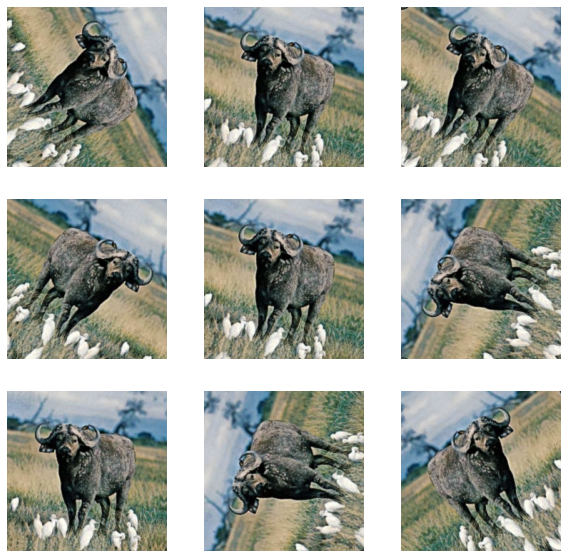

In [102]:
# Take the first batch of images and labels from the training dataset
for image, _ in train_dataset.take(1):
    
    # Create a new figure for the visualization
    plt.figure(figsize=(10, 10)) 
    
    # Take the first image from the batch
    first_image = image[0]
    
    # Generate 9 augmented versions of the first image using random transformations
    for i in range(9):
        
        ax = plt.subplot(3, 3, i + 1)
        # Apply a random data augmentation transformation to the first image
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))

        
        # Rescale the pixel values of the augmented image
        plt.imshow(augmented_image[0] / 255)
        
        # Turn off axis labels
        plt.axis('off')


## Preprocessing
The preprocess_input function performs the following preprocessing steps on the input image:

- Resizes the image to 224 x 224 pixels.
- Converts the image from RGB to BGR color channels.
- Subtracts the mean pixel value for each channel (computed from the training dataset) from each pixel in the image.
- Divides each pixel value by the standard deviation of the pixel values (also computed from the training dataset).
- This preprocessing step is necessary to ensure that the input images are in the same format as the images used to train the VGG16 model. If the input images are not preprocessed in the same way, the model may not perform well on the input data.

In [103]:
# preprocess input using the function from the pre-trained model
preprocess_input = tf.keras.applications.vgg16.preprocess_input

### Creating Base Model
Selecting the base Model as VGG16 and using transfer learning so to take advantagae of the weights in imagenet model

In [104]:
# create base model from the pre-trained model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights = 'imagenet')

## Model Summary

In [105]:
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [106]:
# tf.keras.utils.plot_model(base_model)


## Iteration and feature extraction
 use a pre-trained model in TensorFlow to extract features from a batch of images. iterating through the tarining dataset and extract features from the images

In [107]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

# batchsize, width, height, layer
print(feature_batch.shape)

(32, 7, 7, 512)


## Freezing the base model
At this point setting the trainable setting to 'False' so that the model doesn't learn the features.This can be useful if you want to use a pre-trained model as a feature extractor, and only train the additional layers that you have added to the model.

In [108]:
# freeze the base model
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

 ### Pooling
Pooling layer in TensorFlow to reduce the spatial dimensions of a tensor of features.

In [109]:
# Get a batch of images and labels from the train_dataset
image_batch, label_batch = next(iter(train_dataset))

# Pass the image_batch through the base model to get the features
feature_batch = base_model(image_batch)

# Print the shape of the feature_batch tensor
# The shape is (batch_size, width, height, layer) where  batch_size is the number of images in the batch,
# width and height are the dimensions of the feature maps, and layer is the number of channels in the output feature maps of the final convolutional layer
print(feature_batch.shape)

# Create a GlobalAveragePooling2D layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Apply the GlobalAveragePooling2D layer to the feature_batch tensor to get a tensor of shape (batch_size, n)
# where n is the number of channels in the input feature maps
feature_batch_average = global_average_layer(feature_batch)

# Print the shape of the feature_batch_average tensor
# The shape is (batch_size, n) where batch_size is the number of images in the batch and n is the number of channels
print(feature_batch_average.shape)


(32, 7, 7, 512)
(32, 512)


In [110]:
len(class_names)


4

## Dense Layer
Dense layer in TensorFlow to add a classification layer to a model. Each element in the tensor represents the predicted probability of the corresponding class for the corresponding input image. These probabilities can be used to compute the loss and train the model.

In [111]:
# Use the output as it is, no activation function
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)



use the functional API in TensorFlow to create a model that includes both the input pipeline and the model architecture.

In [112]:
# use functional API to create the entire model, including the input pipeline and model
inputs = tf.keras.Input(shape=IMG_SHAPE) # shape can follow image shape
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [113]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0   

### Compiling
 compile a Keras model with 'Adam' optimizer, Sparse Categorical cross entropy as loss function , and accuracy as evaluation metrics.

In [114]:
# compile
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Evaluate the Model

In [115]:
# Get model performance before training
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)
print('loss:', loss0)
print('accuracy:', accuracy0)

20/20 [==============================] - 3s 120ms/step - loss: 7.7294 - accuracy: 0.2094
loss: 7.7293500900268555
accuracy: 0.20937499403953552


## Saving weights to a txt file

In [116]:
file = open('./Weights.txt', 'w')
for v in model.trainable_weights:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
    
file.close()

## Training and Callback
trains the model with the dataset and defining a Callback in case model doesn't improve

In [117]:
# train the last dense layer we added

logdir = os.path.join("logs", 'model')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[tensorboard_callback])

Epoch 1/20


100/100 [==============================] - 31s 282ms/step - loss: 4.9643 - accuracy: 0.2634 - val_loss: 4.1012 - val_accuracy: 0.3516
Epoch 2/20
100/100 [==============================] - 27s 270ms/step - loss: 3.4955 - accuracy: 0.3803 - val_loss: 2.7347 - val_accuracy: 0.4844
Epoch 3/20
100/100 [==============================] - 28s 277ms/step - loss: 2.5771 - accuracy: 0.4684 - val_loss: 1.7700 - val_accuracy: 0.6187
Epoch 4/20
100/100 [==============================] - 28s 279ms/step - loss: 2.0663 - accuracy: 0.5437 - val_loss: 1.2077 - val_accuracy: 0.6984
Epoch 5/20
100/100 [==============================] - 28s 272ms/step - loss: 1.6034 - accuracy: 0.6062 - val_loss: 0.9094 - val_accuracy: 0.7500
Epoch 6/20
100/100 [==============================] - 28s 279ms/step - loss: 1.3526 - accuracy: 0.6556 - val_loss: 0.6841 - val_accuracy: 0.8094
Epoch 7/20
100/100 [==============================] - 28s 281ms/step - loss: 1.1668 - accuracy: 0.6884 - val_loss: 0.5658 - val_accuracy: 0.8

## Performance metrics
getting the performance metrics from history

In [118]:
# Get the training and validation loss and accuracy from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print(f"train accuracy : {train_acc},\ntrain loss: {train_loss}")
print(f"val accuracy : {val_acc},\nval loss: {val_loss}")

train accuracy : [0.26343750953674316, 0.3803125023841858, 0.4684374928474426, 0.543749988079071, 0.606249988079071, 0.6556249856948853, 0.6884375214576721, 0.7253124713897705, 0.7512500286102295, 0.7756249904632568, 0.776562511920929, 0.7953125238418579, 0.8109375238418579, 0.8296874761581421, 0.8274999856948853, 0.8412500023841858, 0.8471875190734863, 0.8403124809265137, 0.862500011920929, 0.8581249713897705],
train loss: [4.964273452758789, 3.4955430030822754, 2.5770907402038574, 2.066255807876587, 1.603395938873291, 1.3526017665863037, 1.166806697845459, 1.0324255228042603, 0.9139420390129089, 0.8040471076965332, 0.774666428565979, 0.7167030572891235, 0.659196138381958, 0.5937526226043701, 0.5772569179534912, 0.5459963083267212, 0.5143014788627625, 0.5259976983070374, 0.44798851013183594, 0.4679889380931854]
val accuracy : [0.3515625, 0.484375, 0.6187499761581421, 0.698437511920929, 0.75, 0.809374988079071, 0.8343750238418579, 0.862500011920929, 0.8687499761581421, 0.89687502384185

In [119]:
file = open('./Weights.txt', 'a')
for v in model.trainable_weights:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
    
file.close()

 ## Fine tuning
 perform fine-tuning on a pre-trained Keras model by unfreezing some of its layers and training them with a lower learning rate

In [120]:
# Unfreeze base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# Compile using lower learning rate
# using RMSprop to have a more gradual learning
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0   

## Training

In [121]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 20/40


100/100 [==============================] - 28s 252ms/step - loss: 0.4331 - accuracy: 0.8622 - val_loss: 0.1570 - val_accuracy: 0.9547
Epoch 21/40
100/100 [==============================] - 25s 251ms/step - loss: 0.4319 - accuracy: 0.8681 - val_loss: 0.1797 - val_accuracy: 0.9500
Epoch 22/40
100/100 [==============================] - 25s 250ms/step - loss: 0.4256 - accuracy: 0.8716 - val_loss: 0.1910 - val_accuracy: 0.9469
Epoch 23/40
100/100 [==============================] - 25s 249ms/step - loss: 0.4474 - accuracy: 0.8606 - val_loss: 0.1816 - val_accuracy: 0.9500
Epoch 24/40
100/100 [==============================] - 25s 249ms/step - loss: 0.4211 - accuracy: 0.8687 - val_loss: 0.1932 - val_accuracy: 0.9516
Epoch 25/40
100/100 [==============================] - 28s 273ms/step - loss: 0.4194 - accuracy: 0.8694 - val_loss: 0.1936 - val_accuracy: 0.9484
Epoch 26/40
100/100 [==============================] - 26s 252ms/step - loss: 0.4367 - accuracy: 0.8666 - val_loss: 0.1761 - val_accurac

Getting performance metrics

In [122]:
# Get the training and validation loss and accuracy from history
train_loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']
train_acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

print(f"train accuracy : {train_acc},\ntrain loss: {train_loss}")
print(f"val accuracy : {val_acc},\nval loss: {val_loss}")

train accuracy : [0.8621875047683716, 0.8681250214576721, 0.8715624809265137, 0.8606250286102295, 0.8687499761581421, 0.8693749904632568, 0.8665624856948853, 0.8737499713897705, 0.8771874904632568, 0.8665624856948853, 0.8665624856948853, 0.8709375262260437, 0.8675000071525574, 0.8712499737739563, 0.875, 0.8784375190734863, 0.8687499761581421, 0.8734375238418579, 0.8700000047683716, 0.8793749809265137, 0.871874988079071],
train loss: [0.43310755491256714, 0.4319283366203308, 0.4255542755126953, 0.4474441409111023, 0.4210878610610962, 0.4193599820137024, 0.4366625249385834, 0.40390315651893616, 0.379222571849823, 0.4391264021396637, 0.4109709560871124, 0.4201613664627075, 0.4245949983596802, 0.41554147005081177, 0.432896226644516, 0.40371251106262207, 0.41748881340026855, 0.3977247476577759, 0.4325728714466095, 0.41068434715270996, 0.40645137429237366]
val accuracy : [0.9546874761581421, 0.949999988079071, 0.9468749761581421, 0.949999988079071, 0.9515625238418579, 0.948437511920929, 0.95

In [123]:
file = open('./Weights.txt', 'a')
for v in model.trainable_weights:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
    
file.close()

## Testing on test data
Testing the model on test Data and eveluating acuuracy and loss function

In [124]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

5/5 [==============================] - 1s 127ms/step - loss: 0.1532 - accuracy: 0.9625
Test accuracy : 0.9624999761581421
Test loss : 0.15319427847862244


In [125]:
file = open('./Weights.txt', 'a')
for v in model.trainable_weights:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
    
file.close()

## Plotting

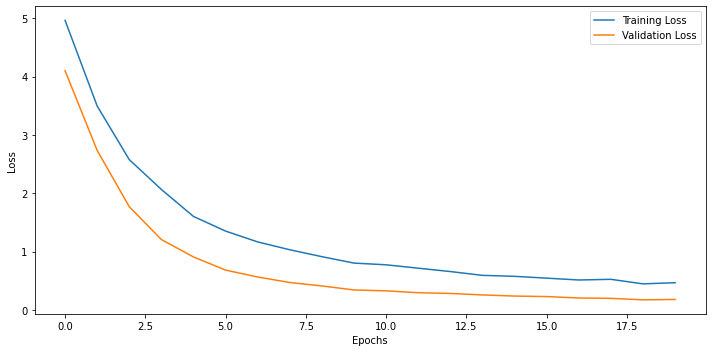

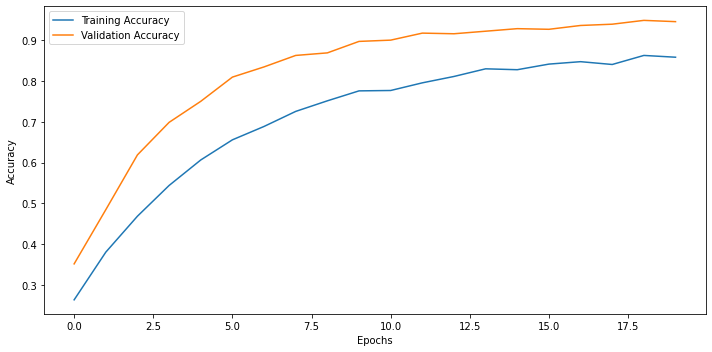

In [126]:
import matplotlib.pyplot as plt

# Get the training and validation loss and accuracy from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()



## Displaying some predictions

Predictions:
 [0 2 2 3 3 0 0 2 0 0 1 1 0 3 0 1 0 0 2 0 2 3 0 0 2 1 1 0 3 3 3 1]
Labels:
 [0 2 2 3 3 0 0 2 0 0 1 0 0 3 0 1 0 0 1 0 2 3 0 0 2 1 2 0 3 3 3 1]


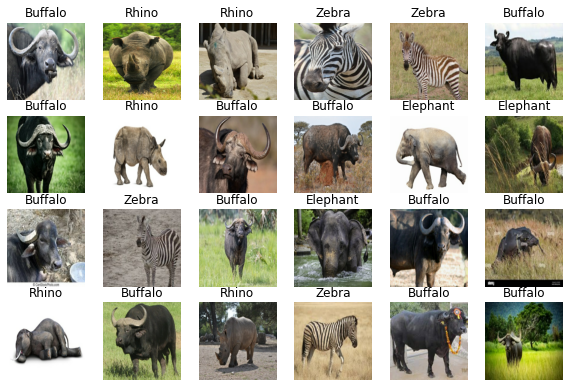

In [127]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch) # predict on 1 batch
pred_label = np.argmax(predictions, axis=1) # get the class index with max predictions

# compare prediction and labels
print('Predictions:\n', pred_label)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(24):
  ax = plt.subplot(6, 6, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[pred_label[i]])
  plt.axis("off")

## Classification report

In [128]:
from sklearn.metrics import classification_report


# Get predicted and true labels
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    predictions = model(images)
    predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
    true_labels.extend(labels.numpy())

# Get classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

confusion_matrix = tf.math.confusion_matrix(
    true_labels, predicted_labels, num_classes=len(class_names))


              precision    recall  f1-score   support

     Buffalo       0.95      0.95      0.95        55
    Elephant       0.93      0.86      0.89        44
       Rhino       0.82      0.92      0.87        25
       Zebra       0.97      0.97      0.97        36

    accuracy                           0.93       160
   macro avg       0.92      0.93      0.92       160
weighted avg       0.93      0.93      0.93       160



## Plotting confusion matrix

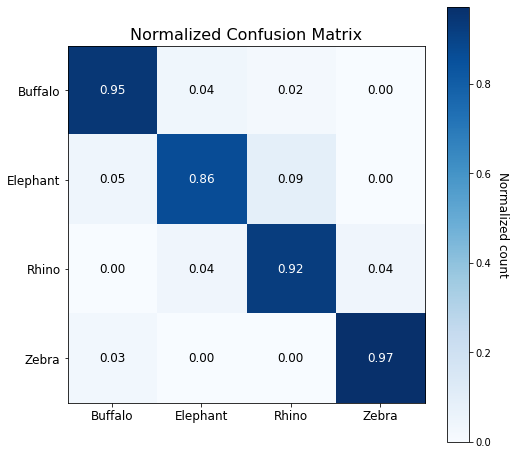

In [129]:
# Normalize the confusion matrix
norm_cm = np.array(confusion_matrix, dtype=np.float32)
for i in range(len(class_names)):
    norm_cm[i] = norm_cm[i] / np.sum(norm_cm[i])

# Plot the confusion matrix

# fig, ax = plt.subplots(figsize=(len(class_names), len(class_names)))
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(norm_cm, cmap=plt.cm.Blues)

# Add labels and ticks
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, fontsize=12)
ax.set_yticklabels(class_names, fontsize=12)

# Set color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Normalized count', rotation=-90, va="bottom", fontsize=12)

# Add annotations
thresh = norm_cm.max() / 2.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, format(norm_cm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if norm_cm[i, j] > thresh else "black",
                fontsize=12)

# Set title and show the plot
ax.set_title("Normalized Confusion Matrix", fontsize=16)
# fig.tight_layout()
plt.show()
